# Computational Genetics: Statistics, Supervised and Unsupervised Learning
### Final Report (using Python)
Olyssa Sperling (614143)
olyssa.sperling@student.hu-berlin.de
[https://github.com/olxssa/Computational_Genomics](https://github.com/olxssa/Computational_Genomics)
Module: Systems Biology: Computational Analysis and Interpretation of High-throughput Data

#### Background
##### 1) CpG methylation data:
CpG methylation data refers to information about the methylation status of cytosine-guanine dinucleotides (CpG sites) in DNA. DNA methylation is an epigenetic modification where a methyl group is added to the 5th carbon of the cytosine ring, primarily at CpG sites. Methylation patterns are crucial for normal development and cellular differentiation. CpG methylation data is often presented as a table with rows as CpG sites and columns as samples.

#####
##### 2) CpG methylation influenced by age:
With age, CpG methylation undergoes a combination of global hypomethylation, localized hypermethylation, and epigenetic drift. These patterns are not just markers of aging but also play active roles in age-related diseases. By studying these changes, researchers can better understand the molecular basis of aging and develop interventions to promote healthy aging.

Key aspects are:
* **Global Hypomethylation**: As individuals age, there is a general loss of methylation across the genome, particularly in repetitive elements and intergenic regions. Hypomethylation in these regions can lead to genomic instability, activation of transposable elements, and inappropriate gene expression


* **Local Hypermethylation**: While global hypomethylation occurs, some specific CpG sites, especially in promoter regions of certain genes, become hypermethylated with age. Hypermethylation often occurs in tumor suppressor genes and pathways involved in cell cycle regulation, contributing to age-related diseases, including cancer.

* **Epigenetic drift**: Epigenetic drift refers to the stochastic (random) changes in DNA methylation patterns that accumulate with age, leading to increased inter-individual variability in methylation profiles over time. This drift is influenced by both genetic and environmental factors, such as diet, smoking, and exposure to pollutants.

* **Age-Associated Differentially Methylated Positions (aDMPs)**: Certain CpG sites show predictable changes in methylation with age, known as age-associated differentially methylated positions (aDMPs). These aDMPs are often enriched in regulatory regions and genes involved in development, such as those in the HOX gene family.

*  **Impact on Health**: 
    * *Cancer*: Age-related methylation changes can lead to hypermethylation of tumor suppressor genes and hypomethylation of oncogenes.
    * *Neurodegeneration*: Methylation changes in genes involved in neuronal function and inflammation contribute to conditions like Alzheimer's disease.
    * *Immune System Decline*: Age-related methylation patterns in immune-related genes contribute to immunosenescence (decline of immune function).

#### The dataset
The dataset contains CpG methylation values per CpG and per individual as a table (“metRmOlWithDbgapId.txt”). Each column is an individual and each row is a CpG, values in the table are methylation values. The subject/sample/individual ids are on the first row. “subjects.txt” has information on the individuals/samples/subjects. The most important attribute here is age. The ids (db gap ids) in this table should match the columns in the first table. There are other attributes such as sex and race.

#### The problem
The main question is what is the relationship between age and methylation? We explore this with the following tasks. 

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##### Task 0
Read tables and merge them or organize them so that you have an age value for each sample/subject. Your predictive variables are CpG methylation values per sample. Ignore other covariates in “subjects.txt” for simplicity, we only care about age. Age can have minus values if the individual is not born yet. 

In [2]:
# First look into subject data

subjects = pd.read_csv('subjects.txt', sep='\t')
subjects.head()

,ID,dbGaP ID,Age,sex,Race
0,1,34,63.000000,M,CAUC
1,2,35,26.531506,F,CAUC
2,3,37,51.479452,F,AA
3,4,39,75.572602,F,CAUC
4,5,40,0.482191,F,AA


In [3]:
# First look into methylation data

data = pd.read_csv('metRmOlWithDbgapId.txt', sep='\t')
data = data.T
data.columns = data.iloc[0]
data = data[1:]
data.head()

dbGapSubjctId,cg26211698,cg03790787,cg04672450,cg14324200,cg04485075,cg19923810,cg21832150,cg02397514,cg08122545,cg20022511,...,cg26059632,cg08555657,cg00152644,cg17761453,cg27626424,cg09448880,cg06275635,cg07039113,cg03165378,cg16139316
34,0.018852,0.068036,0.009639,0.204592,0.010062,0.800023,0.462352,0.010359,0.014241,0.024511,...,0.649459,0.880427,0.953906,0.899846,0.914899,0.868774,0.834703,0.901589,0.888041,0.831972
35,0.023741,0.081941,0.013243,0.064252,0.015012,0.757389,0.12447,0.00959,0.010681,0.023458,...,0.662764,0.846363,0.915651,0.891078,0.922358,0.834874,0.804161,0.868203,0.861794,0.890119
37,0.023376,0.103914,0.010931,0.133139,0.012881,0.739141,0.37957,0.010761,0.011507,0.019871,...,0.676834,0.888116,0.941563,0.891146,0.898969,0.907648,0.793032,0.891126,0.862654,0.839239
39,0.037224,0.051119,0.022289,0.059606,0.047412,0.689842,0.157468,0.011589,0.021806,0.018534,...,0.467848,0.864944,0.925617,0.838163,0.903046,0.726393,0.655513,0.862524,0.815818,0.851132
40,0.018712,0.10411,0.012151,0.092799,0.017496,0.71269,0.129949,0.016549,0.021869,0.035068,...,0.514251,0.851653,0.911592,0.858332,0.92962,0.804251,0.748435,0.863736,0.843227,0.855469


In [4]:
# Merge dataframes based on patient db Gap Subject ID

data.insert(0, 'dbGaP ID', list(data.index))
subjects['dbGaP ID'] = subjects['dbGaP ID'].astype('string')
data_merged = pd.merge(subjects, data, on='dbGaP ID', how='left')
print('Number of patients:', len(data_merged))
print('Number of CpG methylation sites:', len(data_merged.columns) - len(subjects.columns))
data_merged.head()

Number of patients: 108
Number of CpG methylation sites: 1798


,ID,dbGaP ID,Age,sex,Race,cg26211698,cg03790787,cg04672450,cg14324200,cg04485075,...,cg26059632,cg08555657,cg00152644,cg17761453,cg27626424,cg09448880,cg06275635,cg07039113,cg03165378,cg16139316
0,1,34,63.000000,M,CAUC,0.018852,0.068036,0.009639,0.204592,0.010062,...,0.649459,0.880427,0.953906,0.899846,0.914899,0.868774,0.834703,0.901589,0.888041,0.831972
1,2,35,26.531506,F,CAUC,0.023741,0.081941,0.013243,0.064252,0.015012,...,0.662764,0.846363,0.915651,0.891078,0.922358,0.834874,0.804161,0.868203,0.861794,0.890119
2,3,37,51.479452,F,AA,0.023376,0.103914,0.010931,0.133139,0.012881,...,0.676834,0.888116,0.941563,0.891146,0.898969,0.907648,0.793032,0.891126,0.862654,0.839239
3,4,39,75.572602,F,CAUC,0.037224,0.051119,0.022289,0.059606,0.047412,...,0.467848,0.864944,0.925617,0.838163,0.903046,0.726393,0.655513,0.862524,0.815818,0.851132
4,5,40,0.482191,F,AA,0.018712,0.10411,0.012151,0.092799,0.017496,...,0.514251,0.851653,0.911592,0.858332,0.92962,0.804251,0.748435,0.863736,0.843227,0.855469


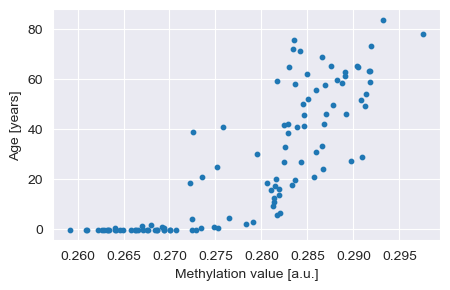

In [22]:
# Take a look if there is a general trend in the data

fig, ax = plt.subplots(figsize=(5, 3))
data_merged['methyl_means'] = data_merged.iloc[:, 5:].mean(axis=1)  # take mean over rows
plt.scatter(data_merged['methyl_means'], data_merged['Age'], s=10)
plt.xlabel('Methylation value [a.u.]')
plt.ylabel('Age [years]')
plt.show()

##### Task 1
Which strategies/methods can be used to test if methylation is predictive of Age in this data set ? List some methods and how they can be used to test this. If possible, give software package names that can be used for the strategies you mention.

| Method                                | Description                                                                                                                                                                                           | Packages                                                                                 |
|---------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------|
| **Correlation**                       | Using coefficients like Pearson correlation values can be calculated and used to show whether methylation significantly depends on age in a linear manner.                                            | scipy.stats                                                                              |
| **Linear Regression**                 | After fitting a single- or multivariate linear model to the data, p-values and R^2 may evaluate the quality of the model and thereby the significance of the correlation between methylation and age. | sklearn.linear_model, statsmodels                                                        |
| **Principal component analysis (PCA)** | When the dimensionality of the methylation data is reduced, the main components contributing to predicting age can be unraveled.                                                                      | sklearn.decomposition.PCA, statsmodels, sklearn.feature_selection.mutual_info_regression |
| **Random Forest**                     | To account for non-linear relationships in the data a random forest can be trained using methylation values as features and age as target.                                                            |          sklearn.ensemble.RandomForestRegressor                                                                                |
| **Support Vector Machine (SVM)** | Incorporates non-linear relationships using kernel functions as well by training a Support Vector Regression (SVR) model using methylation values as input. | sklearn.svm.SVR |
| **Neural Network (NN)** | Is able to take non-linear relationships into account as well using a multi-layer perceptron (MLP) or deep learning model. But since it requires a large dataset for training, artificial data should be generated in this case before application. | numpy, TensorFlow, PyTorch, keras |


##### Task 2: Data processing/preparation tasks

2a. If you want to do some normalization and/or filtering on the variability of predictive features now is the time. Normalization may not be necessary for CpG methylation. The methylation values are bimodal and might be too complicated to first transform them and do normalization (we ideally need some data transformation to make them look more Gaussian). Such transformation & normalization is optional, and may not impact the model performance so much. [Add on: don’t worry about normalization but you might have to do filtering to reduce the number of variables (CpGs) due to limitations in computing power of your workstations but also predictors that are not variable are not likely to impact your model]

2b. Randomly select 10% of the samples as a test set. We do training with cross-validation on the 90% and test performance on the test set.     [Add on: If you can’t figure out how to do this, skip this and rely on CV accuracy only to answer questions]


##### Task 3
 Is methylation predictive of age (previous research indicates so)?  What are the CV performance and test set performance of your model? Pick two strategies you listed for question 1 and implement them to answer this question. 

##### Task 4
 Are all CpGs associated with age? If not, which CpGs are more important for age prediction? Do both methods agree have similar variable importance? Plot importance values as barplots for both methods. [Hint: You need to do some sort of variable importance or variable selection for both methods] 

##### Task 5

5a. Use a sensible cutoff to define “the most important“ using variable importance from both methods. Are you picking the top 10, top 20, or top x percentile? Just define “the top most important”, not really any wrong answers here. Combine the importance metrics from both methods for a unified importance metric, use your imagination here.


5b. Then, make a heatmap using CpG methylation values for the most important CpGs, but only cluster the CpGs. The sample columns should be sorted by age but not clustered. You might be able to see a visual pattern of CpG methylation values that is associated with the age of the samples on the heatmap. Can you observe such a pattern, display the heatmap as described above, and explain the pattern you see in writing? 


##### Task 6
 Pick the top 3 most important variables and build a simple linear model with them to predict the age, what is the performance of this model on the test set? Is it better or worse than the initial machine learning models with more variables? Show an accuracy metric on the test set as bar plot. 